In [1]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
from sklearn.svm import LinearSVC, SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from skimage.feature import hog
from scipy.ndimage.measurements import label

%matplotlib inline

In [2]:
# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

# Define a function to compute color histogram features  
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

# Get hog features
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block),
                                  block_norm= 'L2-Hys',
                                  transform_sqrt=False, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    features = hog(img, orientations=orient, 
                    pixels_per_cell=(pix_per_cell, pix_per_cell),
                    cells_per_block=(cell_per_block, cell_per_block),
                    block_norm= 'L2-Hys',
                    transform_sqrt=False, 
                    visualise=vis, feature_vector=feature_vec)
    return features


# get hog features for all image channels
def get_hog_feature_all_channels(img, orient, pix_per_cell, cell_per_block):
    ch1 = img[:,:,0]
    ch2 = img[:,:,1]
    ch3 = img[:,:,2]
    hf_ch1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=False)
    hf_ch2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=False)
    hf_ch3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=False)
    return hf_ch1, hf_ch2, hf_ch3

# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, cspace='RGB', include_spatial=True, spatial_size=(32, 32),
                     include_hist=True, hist_bins=32, hist_range=(0, 256),
                     include_hog=True, orient=11, pix_per_cell=8, cell_per_block=3, feature_vec=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        img_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2Luv)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
        else:
            feature_image = np.copy(image)      
        # Apply bin_spatial() to get spatial color features
        if include_spatial:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            img_features.append(spatial_features)
        # Apply color_hist() also with a color space option now
        if include_hist:
            hist_features = color_hist(feature_image, nbins=hist_bins, bins_range=hist_range)
            img_features.append(hist_features)
        # include hog features
        if include_hog:
            hf1, hf2, hf3 = get_hog_feature_all_channels(feature_image, orient, pix_per_cell, cell_per_block)
            '''hog_features, hog_img = get_hog_features(feature_image[:,:,0], orient, pix_per_cell, cell_per_block,
                                            vis=True, feature_vec=feature_vec)'''
            hog_features = np.hstack((hf1.ravel(), hf2.ravel(), hf3.ravel()))
            img_features.append(hog_features)
        #print(spatial_features.shape, hist_features.shape, hog_features.shape, feature_image.shape, hf1.shape)
        # Append the new feature vector to the features list
        features.append(np.concatenate(img_features))
    # Return list of feature vectors
    return features


In [3]:
# Read in car and non-car images
car_images = glob.glob('./train/vss/all/*.jpeg')
notcar_images = glob.glob('./train/nvs/all/*.jpeg')
cars = []
notcars = []
for image in car_images:
        cars.append(image)
for image in notcar_images:
        notcars.append(image)

# TODO play with these values to see how your classifier
# performs under different binning scenarios
spatial = 32
histbin = 32
color_space = 'LUV'
orient = 11
pix_per_cell = 8
cell_per_block=3
t0=time.time()
car_features = extract_features(cars, cspace=color_space, spatial_size=(spatial, spatial), include_hist=True,
                        hist_bins=histbin, hist_range=(0, 256),include_hog=True, include_spatial=False,
                        orient=orient, pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, feature_vec=True)
notcar_features = extract_features(notcars, cspace=color_space, spatial_size=(spatial, spatial), include_hist=True,
                        hist_bins=histbin, hist_range=(0, 256),include_hog=True, include_spatial=False,
                        orient=orient, pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, feature_vec=True)
t1=time.time()
print(round(t1-t0, 2), 'Seconds to extract features')
print(len(car_features), len(notcar_features))
# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# Split up data into randomized training and test sets
#rand_state = np.random.randint(0, 100)
print(len(X), len(y))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)#, random_state=rand_state)
print(X_train.shape)
# Fit a per-column scaler only on the training data
X_scaler = StandardScaler().fit(X_train)
# Apply the scaler to X_train and X_test
X_train = X_scaler.transform(X_train)
X_test = X_scaler.transform(X_test)

print('Using spatial binning of:',spatial,
    'and', histbin,'histogram bins')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc = LinearSVC()
#svc = SVC(C=1.0, gamma=10, kernel='rbf')
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()
n_predict = len(y_test)
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 2), 'Seconds to predict', n_predict,'labels with SVC')

16.7 Seconds to extract features
1199 1125
2324 2324
(1859, 10788)
Using spatial binning of: 32 and 32 histogram bins
Feature vector length: 10788
1.72 Seconds to train SVC...
Test Accuracy of SVC =  0.9935
My SVC predicts:  [1. 1. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 1. 1. 1. 0. 0. 1. 1.
 0. 1. 1. 0. 1. 1. 1. 1. 1. 0. 1. 1. 1. 0. 0. 1. 1. 0. 0. 0. 0. 1. 1. 1.
 1. 0. 1. 0. 0. 1. 0. 0. 1. 1. 1. 1. 0. 0. 1. 1. 1. 0. 1. 1. 0. 1. 0. 0.
 0. 1. 1. 0. 0. 0. 1. 0. 1. 1. 0. 1. 1. 0. 0. 1. 0. 1. 0. 1. 0. 0. 1. 0.
 0. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 0. 1. 0. 1. 1. 1. 1. 0. 0. 0. 1. 1.
 0. 0. 1. 0. 0. 0. 1. 1. 1. 0. 1. 0. 0. 1. 0. 1. 0. 1. 1. 0. 0. 1. 0. 0.
 0. 1. 1. 0. 0. 1. 1. 1. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1. 1. 1. 1. 0. 0. 1.
 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 1. 1. 1. 1. 0. 0.
 1. 0. 1. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 1. 1. 1. 0. 1. 0. 0. 0. 1. 0. 1.
 0. 0. 1. 1. 1. 0. 0. 1. 1. 0. 1. 0. 0. 1. 1. 0. 0. 0. 1. 1. 0. 0. 1. 1.
 0. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 1. 1. 0. 0.

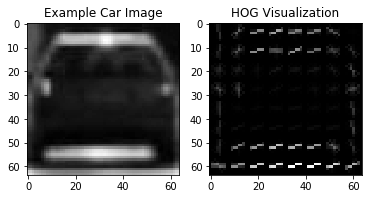

In [4]:
orient = 11
pix_per_cell = 8
cell_per_block=3

img = cv2.imread(cars[1])
img = cv2.cvtColor(img, cv2.COLOR_BGR2LUV)
features, hog_image = get_hog_features(img[:,:,0], orient, pix_per_cell, cell_per_block, vis=True, feature_vec=True)
# Plot the examples
fig = plt.figure()
plt.subplot(121)
plt.imshow(img[:,:,0], cmap='gray')
plt.title('Example Car Image')
plt.subplot(122)
plt.imshow(hog_image, cmap='gray')
plt.title('HOG Visualization')

In [5]:
# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def get_windows(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = img.shape[0]//2
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

In [14]:
class Window:
    def __init__(self):
        self.windows = []
        self.hog_features = None
        self.predictions = []
        self.hot_indexes = []

# get prediction for each window
def get_predictions(classifier, Xscaler, img, window_data, y_start_pos, x_start_pos, cell_per_block, pix_per_cell,
                    inc_spatial, inc_hist, spatial_size = (32, 32), hist_bins = 32, hist_range = (0, 256)):
    predictions = []
    hog_features = window_data.hog_features
    all_windows = window_data.windows
    hog_f1 = hog_features[0]
    hog_f2 = hog_features[1]
    hog_f3 = hog_features[2]
    # loop over windows to get features for
    for i in range(len(all_windows)):
        win_features = []
        # image patch for which to get features
        win = all_windows[i].astype(int)
        tlt, brt = win
        img_win = np.copy(img[tlt[1]:brt[1], tlt[0]:brt[0]])
        img_win = cv2.resize(img_win, (64, 64))
        # get spatial features
        if inc_spatial:
            spf = bin_spatial(img_win, size=spatial_size)
            win_features.append(spf)
        # get color histogram features
        if inc_hist:
            hsf = color_hist(img_win, nbins=hist_bins, bins_range=hist_range)
            win_features.append(hsf)
        # get hog features
        hxs = int((tlt[0] - x_start_pos)//pix_per_cell)    #cell no. equals block no.
        hys = int((tlt[1] - y_start_pos)//pix_per_cell)
        hxe = int((brt[0] - x_start_pos)//pix_per_cell) - cell_per_block + 1   #total blocks in window range
        hye = int((brt[1] - y_start_pos)//pix_per_cell) - cell_per_block + 1
        
        # check for proper shape, modify 6 to calculation with parameters
        shp = hog_f1[hys:hye, hxs:hxe].shape
        if shp[0] != shp[1] or shp[0] < 6:
            predictions.append(0)
            continue
        if hxe > hog_f1.shape[1] or hye > hog_f1.shape[0]:
            predictions.append(0)
            continue
        hog_ch1 = hog_f1[hys:hye, hxs:hxe].ravel()
        hog_ch2 = hog_f2[hys:hye, hxs:hxe].ravel()
        hog_ch3 = hog_f3[hys:hye, hxs:hxe].ravel()
        #print(hys, hye, hxs, hxe, hog_f1[hys:hye, hxs:hxe].shape)
        hgf = np.hstack((hog_ch1, hog_ch2, hog_ch3))
        win_features.append(hgf)
        #features.append(win_features)
        #print(win_features[0].shape, win_features[1].shape, win_features[2].shape, x_start_pos)
        test_features = Xscaler.transform(np.hstack(win_features).reshape(1, -1))
        predictions.append(classifier.predict(test_features))
    return np.array(predictions)

def cool_heat(hot_img, threshold):
    hot_img[hot_img <= threshold] = 0
    return hot_img
    
# find cars in given image by using the given trained classifier
def find_cars(img, classifier, Xscaler):
    global hot_frames
    hot_img = np.zeros_like(img[:,:,0])
    # hog cell details
    orient = 11
    pix_per_cell = 8
    cell_per_block = 3
    spatial = 32
    hbins = 32
    overlap = 0.75
    # multi-window sizes, multiples of hog cell size to ease custom feature extraction
    trained_win_size = 64
    win_sizes = [128, 96, 72, 64, 32]
    # y-axis scan range
    y_fullrange_img = [((img.shape[0]//2)//64)*64, img.shape[0]-48]
    #print(y_fullrange_img)
    y_len = y_fullrange_img[1] - y_fullrange_img[0]
    # range_offsets along x-axis for each window
    x_offset = [0, img.shape[0]//8, img.shape[0]//6, img.shape[0]//6, img.shape[0]//6]
    # range_offsets along y-axis for each window
    y_offset = [0, y_len//8, y_len//6, y_len//6, y_len//4]
    # list of windows for each window size
    all_windows = {128: Window(),
                96: Window(),
                72: Window(),
                64: Window(),
                32: Window()}
    
    # convert to LUV colorspace
    img = cv2.cvtColor(img, cv2.COLOR_RGB2Luv)
    print(img.shape)
    # find boxes and hog features for entire area to be scanned for each window size
    for i in range(len(win_sizes)):
        #print("start again")
        features = []
        # scan range for y-axis
        y_range_img = [y_fullrange_img[0] + y_offset[i], y_fullrange_img[1] - y_offset[i]]
        # get x range for search
        x_range_img = [x_offset[i], image.shape[1] - x_offset[i]]
        # get all the windows in this range
        all_windows[win_sizes[i]].windows = get_windows(img, x_start_stop=x_range_img, y_start_stop=y_range_img, 
                                        xy_window=(win_sizes[i], win_sizes[i]), xy_overlap=(overlap, overlap))
        # resize the image so that current window size scales to 64x64 px, i.e, the size of images in training data
        scale = trained_win_size/win_sizes[i]
        # image patch for which to get hog features
        window_clip = np.copy(img[y_range_img[0]:y_range_img[1]+1, x_range_img[0]:x_range_img[1]+1])
        # resize to scale to window size of 64x64 px
        #print(win_sizes[i], y_range_img, window_clip.shape, scale)
        window_clip = cv2.resize(window_clip, (int(window_clip.shape[1]*scale), int(window_clip.shape[0]*scale)))
        res_img = cv2.resize(img, (int(img.shape[1]*scale), int(img.shape[0]*scale)))
        scaled_ystart = y_range_img[0]*scale
        scaled_xstart = x_range_img[0]*scale
        # get hog features for the entire patch
        all_windows[win_sizes[i]].hog_features = get_hog_feature_all_channels(window_clip, orient, pix_per_cell, cell_per_block)
        #print(y_range_img, x_range_img, len(all_windows[win_sizes[i]].windows))
        #print(all_windows[win_sizes[i]].hog_features[0].shape)
        # scale the windows
        all_windows[win_sizes[i]].windows = np.asarray(all_windows[win_sizes[i]].windows)*scale
        # get predictions for the searched windows
        all_windows[win_sizes[i]].predictions = get_predictions(classifier, Xscaler, res_img, all_windows[win_sizes[i]],
                                                        scaled_ystart, scaled_xstart, cell_per_block,
                                                        pix_per_cell, inc_spatial=False, inc_hist=True,
                                                        spatial_size = (spatial, spatial),
                                                        hist_bins = hbins, hist_range = (0, 256))
        # scale back windows to original size
        all_windows[win_sizes[i]].windows = np.asarray(all_windows[win_sizes[i]].windows)//scale
        all_windows[win_sizes[i]].windows = all_windows[win_sizes[i]].windows.astype(int)
        
        # get indexes on non-zero(car) predictions
        all_windows[win_sizes[i]].hot_indexes = np.array((all_windows[win_sizes[i]].predictions.nonzero())[0])
        # add heat to hot_img
        #print(all_windows[win_sizes[i]].hot_indexes)
        for ind in all_windows[win_sizes[i]].hot_indexes:
            # get corners x-y from hot windows
            tlt, brt = all_windows[win_sizes[i]].windows[ind]
            #weights proportional to size of the window
            hot_img[tlt[1]:brt[1]+1, tlt[0]:brt[0]+1] = hot_img[tlt[1]:brt[1]+1, tlt[0]:brt[0]+1] + (2*(5-i))
    # remove unwanted heat by thresholding
    hot_img = cool_heat(hot_img, 30)
    # weighted average hot_img across 10 older frames
    #nhot_img = np.zeros_like(hot_img)
    #fln = len(hot_frames)
    #ttl = int((fln+1)*(fln+2)/2)
    #for i in range(fln):
    #    nhot_img = nhot_img + (i+1)*hot_frames[i]
    #nhot_img = (nhot_img + ((fln+1)*hot_img))/ttl
    
    #hot_frames.append(nhot_img)
    #if len(hot_frames) > 5:
    #    hot_frames.pop(0)
    # remove unwanted heat by thresholding
    #hot_img = cool_heat(hot_img, 30)
    # normalize the heat
    hot_img = hot_img/(np.max(hot_img))*255
    hot_img.astype(np.uint8)
    return hot_img

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        if abs(bbox[0][0]-bbox[1][0]) >= 80 and abs(bbox[0][1]-bbox[1][1]) >= 80:
            cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

def process_image(img):
    global svc, X_scaler
    labels = label(find_cars(img, svc, X_scaler))
    op = draw_labeled_bboxes(img, labels)
    return op

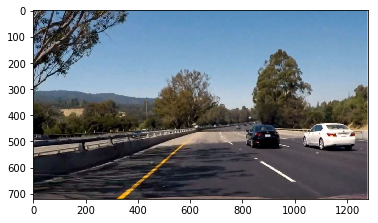

(720, 1280, 3)
Time taken to predict: 6.11


In [12]:
hot_frames = []
image = cv2.imread('./test_images/test7.jpg')
image = cv2.resize(cv2.cvtColor(image, cv2.COLOR_BGR2RGB), (1280, 720))
#image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

plt.imshow(image)
plt.show()
t0 = time.time()
heat_map = find_cars(image, svc, X_scaler)
t1 = time.time()
print("Time taken to predict:", round((t1-t0), 2))

4 cars found


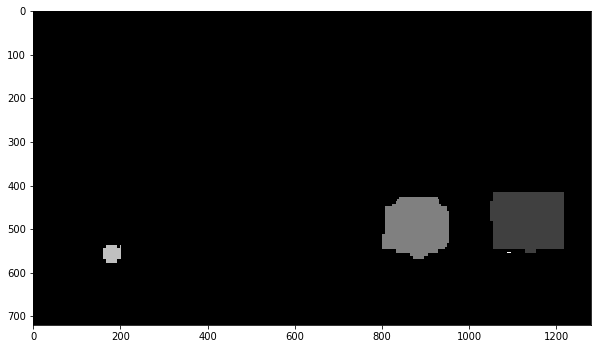

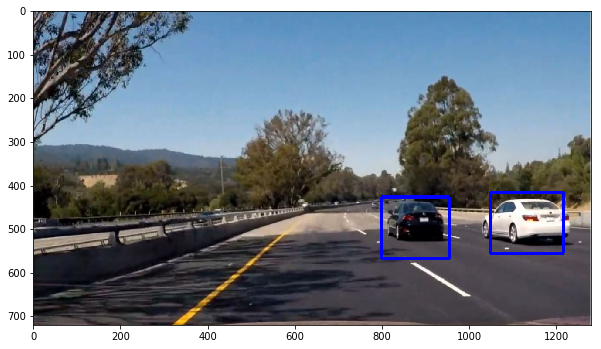

In [13]:
plt.figure(figsize=(10,6))
labels = label(heat_map)
print(labels[1], 'cars found')
plt.imshow(labels[0], cmap='gray')
plt.show()

plt.figure(figsize=(10,6))
op = draw_labeled_bboxes(image, labels)
plt.imshow(op)
plt.show()

In [15]:
from moviepy.editor import VideoFileClip, concatenate_videoclips
from IPython.display import HTML

In [16]:
hot_frames = []

output_vid = './output_videos/test_video.mp4'
in_clip = VideoFileClip("test_video.mp4")

output_clip = in_clip.fl_image(process_image)
%time output_clip.write_videofile(output_vid, audio=False)

(720, 1280, 3)
[MoviePy] >>>> Building video ./output_videos/test_video.mp4
[MoviePy] Writing video ./output_videos/test_video.mp4


  0%|                                                                                           | 0/39 [00:00<?, ?it/s]

(720, 1280, 3)


  3%|██▏                                                                                | 1/39 [00:05<03:44,  5.91s/it]

(720, 1280, 3)


  5%|████▎                                                                              | 2/39 [00:11<03:35,  5.83s/it]

(720, 1280, 3)


  8%|██████▍                                                                            | 3/39 [00:18<03:38,  6.06s/it]

(720, 1280, 3)


 10%|████████▌                                                                          | 4/39 [00:24<03:34,  6.12s/it]

(720, 1280, 3)


 13%|██████████▋                                                                        | 5/39 [00:30<03:24,  6.01s/it]

(720, 1280, 3)


 15%|████████████▊                                                                      | 6/39 [00:35<03:15,  5.91s/it]

(720, 1280, 3)


 18%|██████████████▉                                                                    | 7/39 [00:41<03:07,  5.85s/it]

(720, 1280, 3)


 21%|█████████████████                                                                  | 8/39 [00:47<03:00,  5.81s/it]

(720, 1280, 3)


 23%|███████████████████▏                                                               | 9/39 [00:52<02:53,  5.78s/it]

(720, 1280, 3)


 26%|█████████████████████                                                             | 10/39 [00:58<02:47,  5.77s/it]

(720, 1280, 3)


 28%|███████████████████████▏                                                          | 11/39 [01:04<02:40,  5.74s/it]

(720, 1280, 3)


 31%|█████████████████████████▏                                                        | 12/39 [01:09<02:33,  5.69s/it]

(720, 1280, 3)


 33%|███████████████████████████▎                                                      | 13/39 [01:15<02:27,  5.68s/it]

(720, 1280, 3)


 36%|█████████████████████████████▍                                                    | 14/39 [01:21<02:22,  5.71s/it]

(720, 1280, 3)


 38%|███████████████████████████████▌                                                  | 15/39 [01:27<02:17,  5.72s/it]

(720, 1280, 3)


 41%|█████████████████████████████████▋                                                | 16/39 [01:32<02:11,  5.72s/it]

(720, 1280, 3)


 44%|███████████████████████████████████▋                                              | 17/39 [01:38<02:05,  5.72s/it]

(720, 1280, 3)


 46%|█████████████████████████████████████▊                                            | 18/39 [01:44<02:00,  5.76s/it]

(720, 1280, 3)


 49%|███████████████████████████████████████▉                                          | 19/39 [01:50<01:55,  5.79s/it]

(720, 1280, 3)


 51%|██████████████████████████████████████████                                        | 20/39 [01:56<01:50,  5.81s/it]

(720, 1280, 3)


 54%|████████████████████████████████████████████▏                                     | 21/39 [02:01<01:44,  5.81s/it]

(720, 1280, 3)


 56%|██████████████████████████████████████████████▎                                   | 22/39 [02:07<01:38,  5.80s/it]

(720, 1280, 3)


 59%|████████████████████████████████████████████████▎                                 | 23/39 [02:13<01:32,  5.77s/it]

(720, 1280, 3)


 62%|██████████████████████████████████████████████████▍                               | 24/39 [02:19<01:27,  5.82s/it]

(720, 1280, 3)


 64%|████████████████████████████████████████████████████▌                             | 25/39 [02:25<01:21,  5.81s/it]

(720, 1280, 3)


 67%|██████████████████████████████████████████████████████▋                           | 26/39 [02:30<01:15,  5.78s/it]

(720, 1280, 3)


 69%|████████████████████████████████████████████████████████▊                         | 27/39 [02:36<01:09,  5.77s/it]

(720, 1280, 3)


 72%|██████████████████████████████████████████████████████████▊                       | 28/39 [02:42<01:03,  5.77s/it]

(720, 1280, 3)


 74%|████████████████████████████████████████████████████████████▉                     | 29/39 [02:48<00:59,  5.99s/it]

(720, 1280, 3)


 77%|███████████████████████████████████████████████████████████████                   | 30/39 [02:54<00:53,  5.95s/it]

(720, 1280, 3)


 79%|█████████████████████████████████████████████████████████████████▏                | 31/39 [03:00<00:47,  5.96s/it]

(720, 1280, 3)


 82%|███████████████████████████████████████████████████████████████████▎              | 32/39 [03:06<00:41,  5.96s/it]

(720, 1280, 3)


 85%|█████████████████████████████████████████████████████████████████████▍            | 33/39 [03:12<00:35,  5.91s/it]

(720, 1280, 3)


 87%|███████████████████████████████████████████████████████████████████████▍          | 34/39 [03:18<00:29,  5.91s/it]

(720, 1280, 3)


 90%|█████████████████████████████████████████████████████████████████████████▌        | 35/39 [03:25<00:24,  6.13s/it]

(720, 1280, 3)


 92%|███████████████████████████████████████████████████████████████████████████▋      | 36/39 [03:30<00:18,  6.03s/it]

(720, 1280, 3)


 95%|█████████████████████████████████████████████████████████████████████████████▊    | 37/39 [03:36<00:11,  5.92s/it]

(720, 1280, 3)


 97%|███████████████████████████████████████████████████████████████████████████████▉  | 38/39 [03:42<00:05,  5.83s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./output_videos/test_video.mp4 

Wall time: 3min 44s


In [20]:
HTML("""
<video style='width:960px;height:540px' controls>
  <source src="{0}">
</video>
""".format('./output_videos/test_video.mp4'))